## PINNs - Physical informed neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [46]:
# Calor 1D:

def heat_equation1D(dif, plate_length, nx,
                    initial_cond, cc_left, cc_right,
                    nt=1000):

  dx  = plate_length/nx
  dx2 = dx**2

  xi  = np.linspace(0,plate_length, nx)

  dt = dx2/(4*dif)
  ti  = np.arange(0,nt,dt)

  assert dt <= dx2/(4*dif), 'stability criteria not achieved'

  u = np.zeros((len(ti), nx))
  #condição inicial
  u[0,:] = initial_cond
  #condição de contorno
  u[:,0]  = cc_left
  u[:,nx-1] = cc_right

  constante = dt*dif/(dx2)

  for k in tqdm(range(0,len(ti)-1)):
    for i in range(1,nx-1):
      u[k+1,i] = u[k,i] + constante*(u[k,i+1] - 2*u[k,i] + u[k,i-1])

  return ti, xi,u

  0%|          | 0/1249999 [00:00<?, ?it/s]

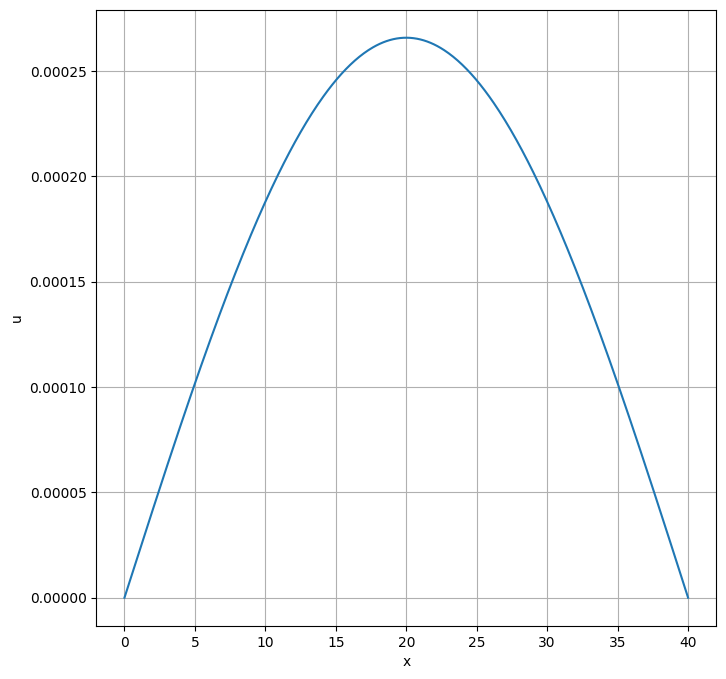

In [128]:
tt, xx, sol = heat_equation1D(2,40,500,50,0,0)

plt.figure(1, figsize=(8,8))
plt.plot(xx,sol[-1,:])
plt.xlabel('x')
plt.ylabel('u')
plt.grid()
plt.show()

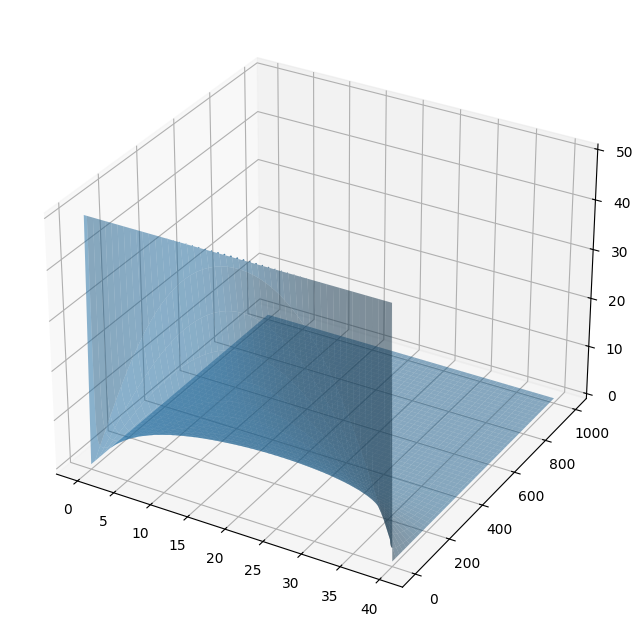

In [48]:
X, Y = np.meshgrid(xx, tt)

plt.figure(2, figsize=(8,8))
ax1 = plt.axes(projection="3d")
ax1.plot_surface(X, Y, sol,
                alpha=0.5)
plt.show()

In [129]:
# solucao analitica:
from scipy.integrate import quad
import sympy as sp  

x = sp.symbols('x')                                
n = sp.symbols('n', real=True, nonzero=True)       
L = 40
D = 2
f_init = 50
cn_integrate  = f_init*sp.sin((n*sp.pi*x)/L)
result_cn_int = sp.integrate(cn_integrate, (x, 0, L))   
cn = sp.lambdify(n, (2/L)*(result_cn_int))
cn(1)

63.66197723675813

In [130]:
def u_analitica(n,x,pos_t):

    final_sol = []

    for j in range(len(x)):
        soma = 0
        for i in range(n):
            soma = soma + cn(i+1)*np.exp(-(((i+1)**2)*(np.pi**2)*D*tt[pos_t])/L**2)*np.sin(((i+1)*np.pi*x[j])/L)
        
        final_sol.append(soma)
    return final_sol

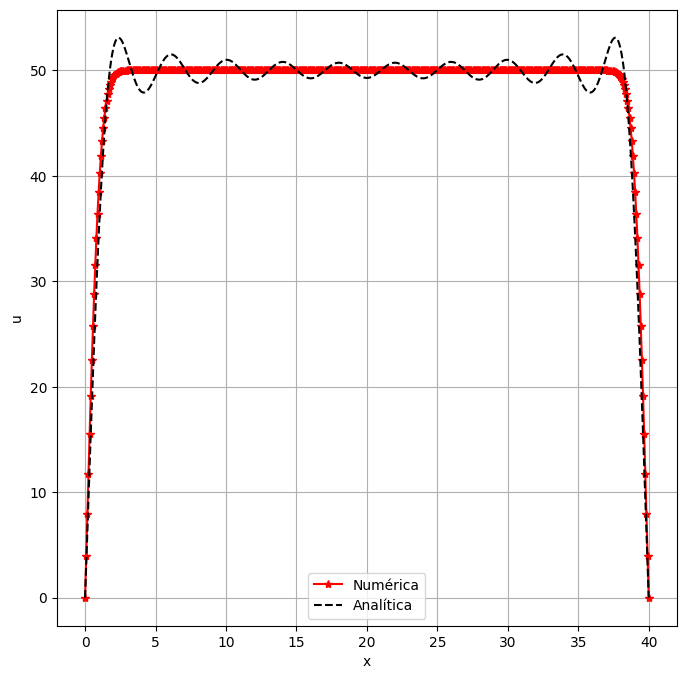

In [136]:
tempo  = 200
res = u_analitica(20, xx, tempo)

plt.figure(3, figsize=(8,8))
plt.plot(xx,sol[tempo,:], '*-r', label = 'Numérica')
plt.plot(xx,res, '--k', label = 'Analítica')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.show()

In [151]:
import torch
import torch.nn as nn

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.double() 
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


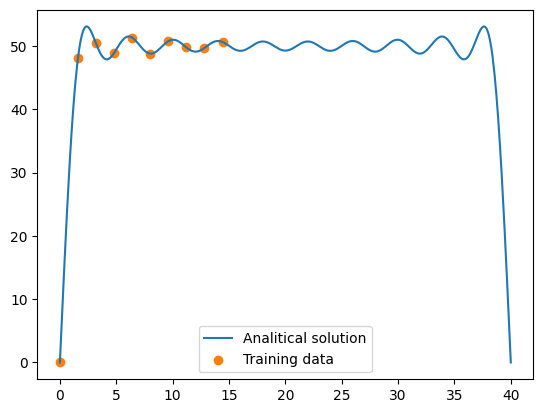

In [140]:
res_tt = torch.from_numpy(np.array(res))
xx_tt  = torch.from_numpy(xx)
res_tt = res_tt.view(-1,1)
xx_tt = xx_tt.view(-1,1)
print(xx_tt.shape, res_tt.shape)

x_data = xx_tt[0:200:20]
y_data = res_tt[0:200:20]
print(x_data.shape, y_data.shape)

plt.plot(xx_tt, res_tt, label="Analitical solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

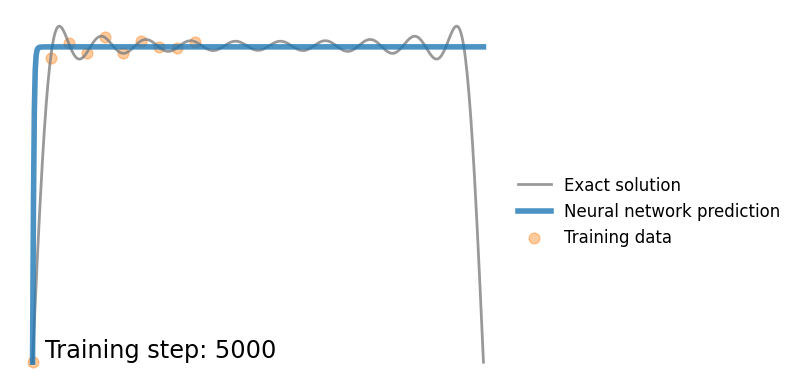

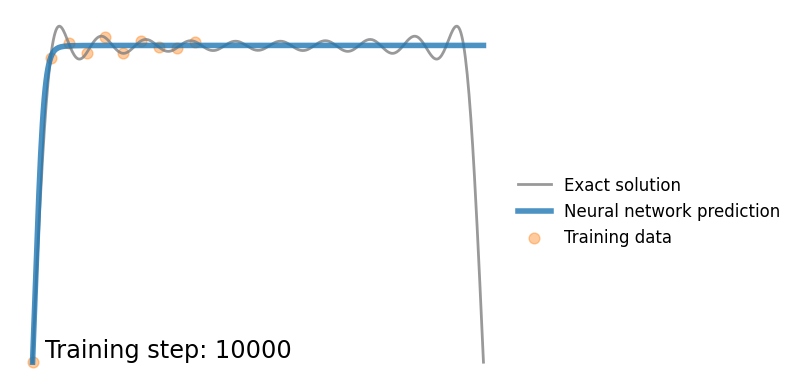

In [144]:
#train NN

def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    #plt.xlim(-0.05, 1.05)
    #plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")


torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(10000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(xx_tt).detach()
        
        plot_result(xx_tt,res_tt,x_data,y_data,yh)
        
        # file = "plots/nn_%.8i.png"%(i+1)
        # plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        # files.append(file)
    
        if (i+1) % 5000 == 0: plt.show()
        else: plt.close("all")

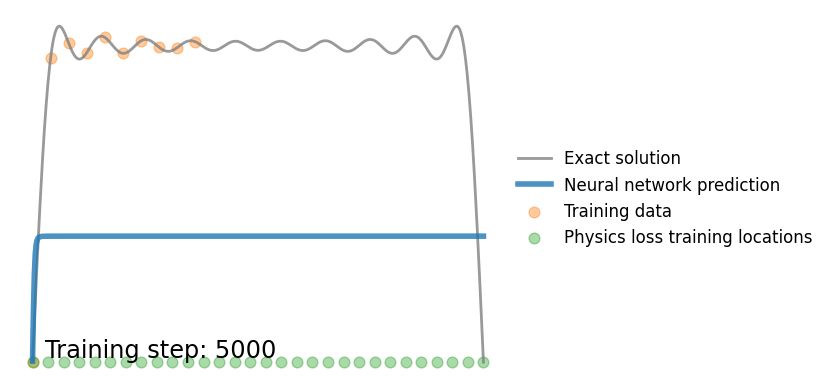

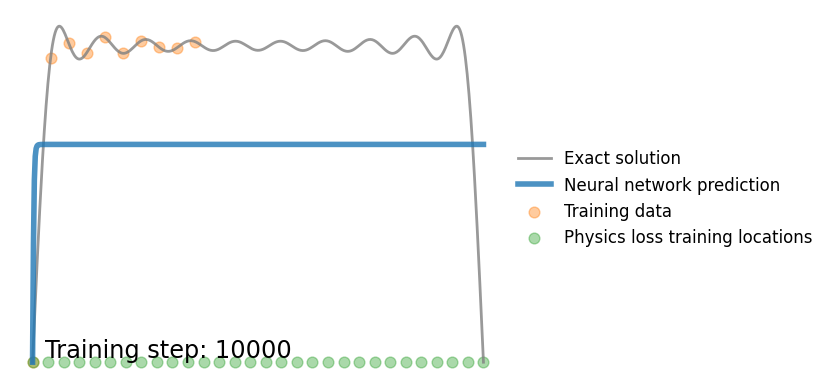

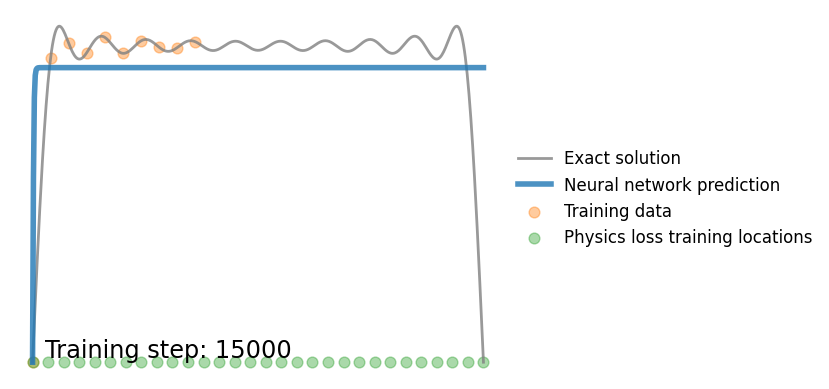

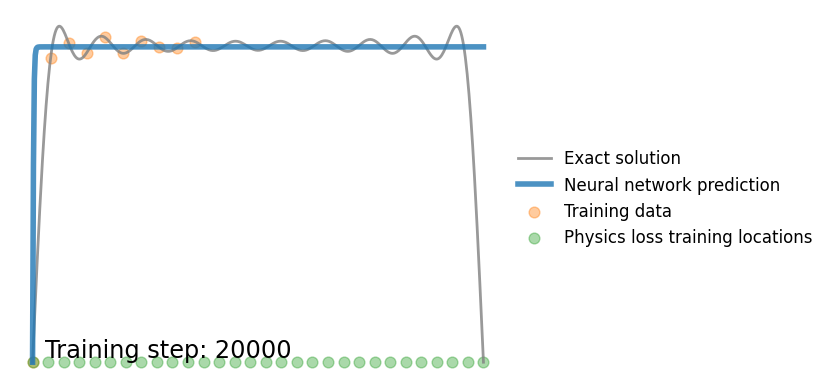

In [157]:
#PINN
x_physics = torch.linspace(0,40,30).view(-1,1).requires_grad_(True)
M = 20000

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
for i in range(M):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    yhp = model(x_physics.to(torch.float64))
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = D*dx2 # computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1/M)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(xx_tt).detach()
        xp = x_physics.detach()
        
        plot_result(xx_tt,res_tt,x_data,y_data,yh,xp)
        
        # file = "plots/nn_%.8i.png"%(i+1)
        # plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        # files.append(file)
    
        if (i+1) % 5000 == 0: plt.show()
        else: plt.close("all")    

'torch.FloatTensor'